# Abacus : https://lgarrison.github.io/AbacusCosmos/

In [1]:
import numpy as np

from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt

import pandas as pd

import h5py

import time

from scipy.interpolate import splrep, splev
from scipy.integrate import quad

from halotools.sim_manager import UserSuppliedHaloCatalog, UserSuppliedPtclCatalog,FakeSim, CachedHaloCatalog
from halotools.mock_observables import delta_sigma, wp, return_xyz_formatted_array
from halotools.empirical_models import NFWProfile
from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory
from halotools.empirical_models import AssembiasZheng07Cens, AssembiasZheng07Sats, TrivialPhaseSpace, NFWPhaseSpace
from halotools.utils import add_halo_hostid
from halotools.mock_observables.surface_density.surface_density_helpers import annular_area_weighted_midpoints

import baryonification as bfc
from baryonification.useful_functions import DeltaSigmas_from_density_profile, cvir_fct

from tabcorr import TabCorr

from astropy.cosmology import Planck15


In [ ]:
def create_halo_and_particle_catalogs_for_halotools(halo_catalog_path, particle_catalog_path):
    halo_df = pd.read_csv(halo_catalog_path)
    particles_df = pd.read_csv(particle_catalog_path, delimiter =' +',  names=['x','y','z'], engine='python')
    print('Files read.')
    
    ptcl_x = particles_df['x'].values
    ptcl_y = particles_df['y'].values
    ptcl_z = particles_df['z'].values

    particle_mass = 1.51e9
    num_ptcl_per_dim = 3840
    x = halo_df['x'].values
    y = halo_df['y'].values
    z = halo_df['z'].values
    vx = halo_df['vx'].values
    vy = halo_df['vy'].values
    vz = halo_df['vz'].values
    mass = halo_df['Mvir'].values
    radius = halo_df['Rvir'].values/1e3 #convert to Mpc
    ids = np.arange(0, len(halo_df))
    upid = halo_df['upId'].values
    simname = 'MDPL2'
    
    #get concentrations
#     nfw = NFWProfile(redshift=redshift, cosmology = Planck15, mdef = 'vir', conc_mass_model = 'dutton_maccio14')
#     model_conc = nfw.conc_NFWmodel(prim_haloprop = mass)
    concentrations = halo_df['Rvir'].values / halo_df['Rs'].values
    
    print('Creating catalogs...')
    particle_catalog = UserSuppliedPtclCatalog(x = ptcl_x, y = ptcl_y, z = ptcl_z, Lbox = Lbox, particle_mass = particle_mass,
                                  redshift = redshift)
    halo_catalog = UserSuppliedHaloCatalog(user_supplied_ptclcat = particle_catalog, redshift = redshift, simname = simname,
                                       Lbox = Lbox, particle_mass = particle_mass, num_ptcl_per_dim =num_ptcl_per_dim,
                                       halo_x = x, halo_y = y, halo_z = z,
                                       halo_vx = vx, halo_vy = vy, halo_vz = vz, 
                                       halo_id = ids, halo_mvir = mass, halo_rvir = radius,
                                       halo_nfw_conc = concentrations, halo_upid = upid )
    
    #add hostid
    add_halo_hostid(halo_catalog.halo_table)
    
    return halo_catalog, particle_catalog

file directory: https://nbody.rc.fas.harvard.edu/public/AbacusCosmos/AbacusCosmos_1100box_products/AbacusCosmos_1100box_17_products/AbacusCosmos_1100box_17_rockstar_halos/z0.500/

header: https://nbody.rc.fas.harvard.edu/public/AbacusCosmos/AbacusCosmos_1100box_products/AbacusCosmos_1100box_17_products/AbacusCosmos_1100box_17_rockstar_halos/z0.500/header

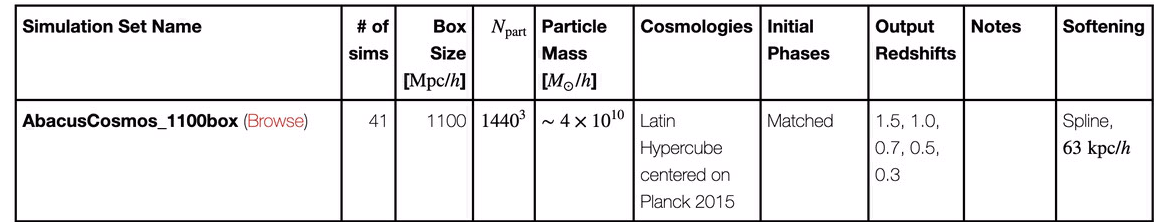

In [39]:
sim_name = 'abacus'

H0 = 62.08498
Omega_DE = 0.657979686739
Omega_K = 0.0
Omega_M = 0.342020313261
sigma_8 = 0.7140871
w0 = -0.7448834

particle_mass_Msun = 6.813281236846442e10
particle_mass_hMsun =4.230024293239867e10
num_ptcl_per_dim = 1440

redshift = 0.5

box_size_Mpc = 1771.765087143460050
box_size_hMpc = 1100.000000000000000

In [8]:
data_directory = '/Users/fardila/Documents/Data/baryonic_effects/abacus/'
halo_cat_file = 'halos/halos_0.0.h5'
particle_cat_file = 'particles/particles_0.0.h5'

In [45]:
f = h5py.File(data_directory+halo_cat_file, 'r')
f['halos'].dtype

halo_positions = f['halos']['pos']%box_size_hMpc
halo_positions_x = halo_positions[:,0]
halo_positions_y = halo_positions[:,1]
halo_positions_z = halo_positions[:,2]

halo_velocities = f['halos']['vel']
halo_velocities_x = halo_velocities[:,0]
halo_velocities_y = halo_velocities[:,1]
halo_velocities_z = halo_velocities[:,2]

halo_ids = f['halos']['id']
halo_parent_ids = f['halos']['parent_id']

halo_mvirs = f['halos']['m']
halo_rvirs = f['halos']['r']
halo_rscales = f['halos']['rs']
halo_concentrations = halo_rvirs / halo_rscales

# Masses in Msun / h
# Positions in Mpc / h (comoving)
# Velocities in km / s (physical, peculiar)
# Halo Distances, Lengths, and Radii in kpc / h (comoving)

f.close()

In [55]:
f = h5py.File(data_directory+particle_cat_file, 'r')
f['particles'].dtype

particle_positions = f['particles']['pos']%box_size_hMpc
particle_positions_x = particle_positions[:,0]
particle_positions_y = particle_positions[:,1]
particle_positions_z = particle_positions[:,2]
# particle_positions = return_xyz_formatted_array(x, y, z, period=period)

particle_velocities = f['particles']['vel']
particle_velocities_x = particle_velocities[:,0]
particle_velocities_y = particle_velocities[:,1]
particle_velocities_z = particle_velocities[:,2]

particle_ids = f['particles']['id']

f.close()

In [50]:
particle_catalog = UserSuppliedPtclCatalog(x = particle_positions_x,
                                           y = particle_positions_y,
                                           z = particle_positions_z,
                                           Lbox = box_size_hMpc,
                                           particle_mass = particle_mass_Msun,
                                           redshift = redshift)
downsampling_factor = (num_ptcl_per_dim**3)/float(len(particle_catalog.ptcl_table))

In [48]:
halo_catalog = UserSuppliedHaloCatalog(user_supplied_ptclcat = particle_catalog,
                                       redshift = redshift,
                                       simname = sim_name,
                                       Lbox = box_size_hMpc,
                                       particle_mass = particle_mass_Msun,
                                       num_ptcl_per_dim =num_ptcl_per_dim,
                                       halo_x = halo_positions_x, halo_y = halo_positions_y, halo_z = halo_positions_z,
                                       halo_vx = halo_velocities_x, halo_vy = halo_velocities_y, halo_vz = halo_velocities_z,
                                       halo_id = halo_ids,
                                       halo_mvir = halo_mvirs, halo_rvir = halo_rvirs,
                                       halo_nfw_conc = halo_concentrations,
                                       halo_upid = halo_parent_ids )

#add hostid
add_halo_hostid(halo_catalog.halo_table)

In [56]:
time1 = time.time()


# First, we tabulate the correlation functions in the halo catalog.
rp_bins = np.logspace(-1, 1, 20)

halotab = TabCorr.tabulate(halo_catalog,
                           delta_sigma,
                           particle_positions,
                           rp_bins = rp_bins,
                           mode ='cross',
                           period = box_size_hMpc,
                           particle_masses = particle_mass_Msun,
                           downsampling_factor = downsampling_factor )

# We can save the result for later use.
halotab.write(data_directory+'TabCorr/abacus_TabCorr_DS.hdf5')

print('{0} seconds'.format(time.time() - time1)) 

/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


Number of tracer particles: 674513
92.33673310279846 seconds


## TODO: check units are correct for halotools